### **Phase 1: Player Detection and Initial Analysis** 🏃‍♂️⚽️

1. **YOLOv11 Fine-Tuning for Player Detection** 🎯
   - Adapt YOLOv11 for detecting football players on the field.
   - **Objective**: Ensure robust detection of players, even under challenging scenarios like crowded scenes or varying lighting conditions.

In [ ]:
import torch
print(torch.backends.mps.is_available())
print(torch.cuda.is_available())

False
True


In [10]:
!yolo task=detect mode=train model="/content/drive/MyDrive/FootCVision/utils/yolo11s.pt" data="/content/drive/MyDrive/dataset/data.yaml" epochs=10 imgsz=640 device=0

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/FootCVision/utils/yolo11s.pt, data=/content/drive/MyDrive/dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

**Fine-tuned YOLOv11s Model Summary**

Model Specifications:
- **Architecture:** YOLOv11s (fused)
- **Layers:** 238 layers
- **Parameters:** 9,414,348
- **Gradients:** 0 gradients
- **FLOPs (Floating Point Operations):** 21.3 GFLOPs

Inference Speed:
- **Preprocessing Time:** 0.3ms per image
- **Inference Time:** 4.7ms per image
- **Loss Calculation Time:** 0.0ms per image
- **Postprocessing Time:** 2.7ms per image

---

### Performance Metrics:

| **Class**       | **Images** | **Instances** | **Precision (P)** | **Recall (R)** | **mAP@50** | **mAP@50-95** |
|-----------------|------------|---------------|-------------------|----------------|------------|---------------|
| **All**         | 588        | 4137          | 0.923             | 0.897          | 0.928      | 0.633         |
| **Ball**        | 538        | 611           | 0.891             | 0.769          | 0.845      | 0.594         |
| **Goalkeeper**  | 115        | 116           | 0.973             | 0.924          | 0.974      | 0.623         |
| **Player**      | 181        | 3074          | 0.938             | 0.961          | 0.961      | 0.682         |
| **Referee**     | 171        | 336           | 0.890             | 0.935          | 0.932      | 0.634         |

Inference Speed:
- **Total Speed:** 1.68 iterations per second


![RESULTS](/Users/alyazouzou/Desktop/CV_Football/FootCVision/phase1/runs/detect/train/results.png)

1.3 **Inference on a Video** !

In [ ]:
!yolo task=detect mode=predict model="/Users/alyazouzou/Desktop/CV_Football/FootCVision2/phase1/runs/detect/train/weights/best.pt" source="/Users/alyazouzou/Desktop/CV_Football/vids/demo.mov" device=mps project="/Users/alyazouzou/Desktop/CV_Football/vids" name="output"

2. **Conformal Object Detection with puncc library** 📏

In [1]:
import os
import glob
import numpy as np
from PIL import Image
from inference import PlayerInference
from odwrapper import YOLOAPIWrapper

from deel.puncc.object_detection import SplitBoxWise
from deel.puncc.metrics import object_detection_mean_coverage, object_detection_mean_area
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

In [2]:
#function to parse the dataset and extract the images, ground truth boxes and labels for only a proportion of the dataset
dataset_path = "/Users/alyazouzou/Desktop/CV_Football/dataset"
train_images_path = os.path.join(dataset_path, "train/images")
train_labels_path = os.path.join(dataset_path, "train/labels")

def parse_yolo_dataset(images_path, labels_path, percentage=0.1, random_seed=42):
    """
    Parse a subset of the YOLO dataset (e.g., 1%) and extract image paths, ground truth boxes, and labels.
    Args:
        images_path (str): Path to the images folder.
        labels_path (str): Path to the labels folder.
        percentage (float): Percentage of data to parse (e.g., 0.01 for 1%).
        random_seed (int): Random seed for reproducibility.
    Returns:
        Tuple[List[str], List[np.ndarray], List[List[int]]]: Subsampled image paths, ground truth boxes, and labels.
    """
    # Get all label files
    label_files = glob.glob(os.path.join(labels_path, "*.txt"))

    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Determine the number of files to sample
    total_files = len(label_files)
    sample_size = int(percentage * total_files)

    # Randomly select a subset of files
    sampled_files = np.random.choice(label_files, size=sample_size, replace=True)

    #store the image paths, ground truth boxes and labels
    image_paths = []
    ground_truth_boxes = []
    all_labels = []

    for label_file in sampled_files:
        with open(label_file, "r") as f:
            labels = f.readlines()

        # Extract bounding boxes and associated class IDs
        boxes = []
        labels_per_image = []
        for label in labels:
            parts = list(map(float, label.strip().split()))
            class_id, x_center, y_center, width, height = parts
            # normalizing the bounding box coordinates
            image_file = os.path.join(images_path, os.path.basename(label_file).replace(".txt", ".jpg"))
            image = Image.open(image_file)
            image_width, image_height = image.size
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height
            # converting YOLO format to bounding box (x1, y1, x2, y2)
            x1 = x_center - (width / 2)
            y1 = y_center - (height / 2) 
            x2 = x_center + (width / 2)
            y2 = y_center + (height / 2) 
            #convert to numpy array and append to boxes
            boxes.append([x1, y1, x2, y2])
            box = np.array(boxes)
            labels_per_image.append(int(class_id))

        # Add the image path, boxes, and labels
        image_file = os.path.join(images_path, os.path.basename(label_file).replace(".txt", ".jpg"))
        image_paths.append(image_file)
        ground_truth_boxes.append(box)
        all_labels.append(labels_per_image)

    return image_paths, ground_truth_boxes, all_labels


# application of the function to the dataset
image_paths, ground_truth_boxes, all_labels = parse_yolo_dataset(train_images_path, train_labels_path, percentage=0.70, random_seed=42)

# Convert to numpy arrays for compatibility with puncc
X = np.array(image_paths)
y = np.array(ground_truth_boxes, dtype=object)  
labels = np.array(all_labels, dtype=object)  
# we use dtype=object for variable-length arrays - this is necessary for puncc - because the number of boxes per image can vary

# we split the data into training and validation sets
X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(X, y, labels, test_size=0.2, random_state=42)

After getting our train set that is considered as our calibration set for conformal prediction, we have to create a wrapper of my YOLO fine-tuned model. This is necessary to ensure that we have stored **X_pred** (which is the prediction done by the fine tuned model for all images on the train set) & **X_ground_truth** (which is the ground truth).

In [4]:
yolo_api = YOLOAPIWrapper(model_path="/Users/alyazouzou/Desktop/CV_Football/FootCVision/phase1/runs/detect/train/weights/best.pt")

In [5]:
# example of prediction and matching
print(yolo_api.predict_and_match(X_train[0], y_train[0]))


image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/d404b4cbcfa141cb_jpg.rf.225135995b6a47cd4b2f9bd5167a5a39.jpg: 640x640 2 balls, 98.0ms
Speed: 0.8ms preprocess, 98.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
(array([[     283.45,      454.34,      311.48,      495.35],
       [      505.5,      301.26,       536.7,      349.39]], dtype=float32), array([[        279,         452,         317,         499],
       [      504.5,         300,       537.5,         349]]), array([ True,  True]))


In [6]:
from deel.puncc.api.prediction import IdPredictor
from deel.puncc.object_detection import SplitBoxWise

# we create the proxy for the object detection model as suggested in the documentation
api_model = IdPredictor()

In [9]:
# we call the query method to get the predictions and the matched ground truth boxes which are our calibration data
y_preds, y_trues_matched, images, classes = yolo_api.query(X_train, y_train, labels_train)

print("Predictions:", y_preds)
print("Matched Ground Truths:", y_trues_matched)
print("Images:", images)
print("Classes:", classes)

Predictions: [[     283.45      454.34      311.48      495.35]
 [      505.5      301.26       536.7      349.39]
 [     252.02      281.46      357.16      406.04]
 ...
 [      258.4      129.59       270.6       178.2]
 [     162.21      236.84      180.09      304.37]
 [     379.94       540.3      415.05      592.22]]
Matched Ground Truths: [[        279         452         317         499]
 [      504.5         300       537.5         349]
 [        253       280.5         353       400.5]
 ...
 [        259       129.5         271       179.5]
 [      161.5         236       179.5         306]
 [        381         542         414         591]]
Images: ['/Users/alyazouzou/Desktop/CV_Football/dataset/train/images/d404b4cbcfa141cb_jpg.rf.225135995b6a47cd4b2f9bd5167a5a39.jpg', '/Users/alyazouzou/Desktop/CV_Football/dataset/train/images/a21ceb4572742c17_jpg.rf.646c28d371d9e64fe0e4db783ad668da.jpg', '/Users/alyazouzou/Desktop/CV_Football/dataset/train/images/3148_jpg.rf.6142ace43db98

In [35]:
# we instantiate the conformal predictor
conformal_predictor = SplitBoxWise(api_model, method="multiplicative", train=False)

# fitting the conformal predictor on the calibration data
conformal_predictor.fit(X_calib=y_preds, y_calib=y_trues_matched)

**Inference on one Test Image**

In [36]:
# Select an image from the test dataset
image_path, bboxes, classes = X_val[91], y_val[91], labels_val[91]
#print(bboxes.shape)

# Predict on the image
y_new_api = yolo_api.predict_from_image(image_path)
#print(y_new_api.shape)
#print(y_new_api)

# the coverage target 1-alpha
alpha = 0.3

# Inference + UQ
y_pred_new, box_inner, box_outer = conformal_predictor.predict(y_new_api, alpha=alpha)
#print(box_outer.shape)
#print(box_outer)

# Convert the predictions for comparison necessary for the plotting
classes = [str(class_) for class_ in classes]
y_pred_new_t = tuple(map(tuple, y_pred_new))
bboxes_t = tuple(map(tuple, bboxes))
box_inner_t = tuple(map(tuple, box_inner))
box_outer_t= tuple(map(tuple, box_outer))
image = Image.open(image_path)


image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/123_jpg.rf.63afe2add1fe69757d58448e43bef38a.jpg: 640x640 1 ball, 12 players, 2 referees, 128.9ms
Speed: 1.4ms preprocess, 128.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


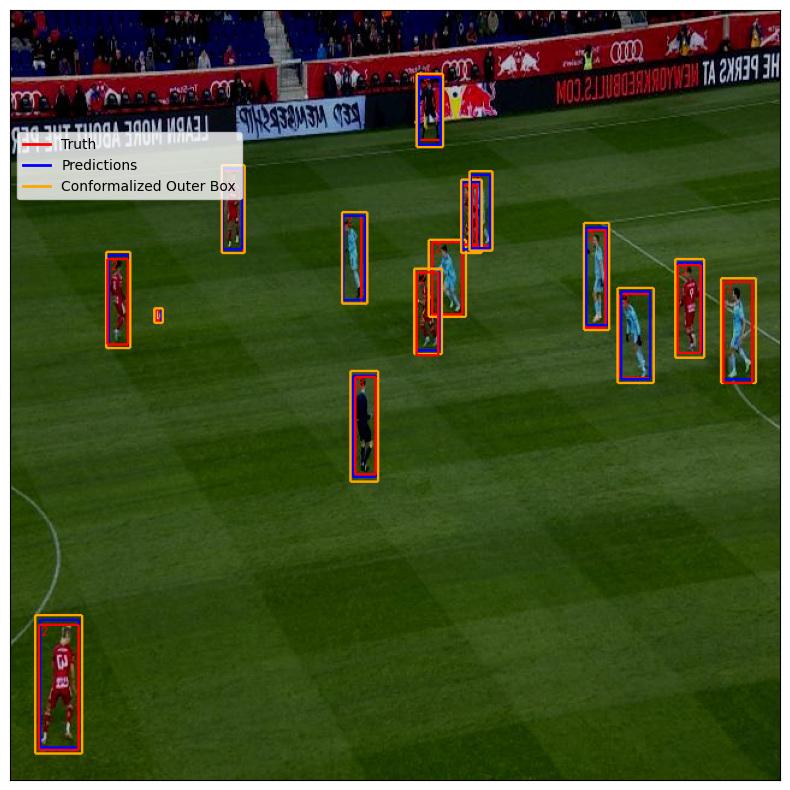

In [37]:
from deel.puncc.plotting import draw_bounding_box

for i in range(len(y_pred_new)):
    image_with_bbox = draw_bounding_box(
        image=image,
        box=bboxes_t[i],
        label=classes[i],
        legend="Truth",
        color="red",
    )
    image_with_bbox = draw_bounding_box(
        image=image,
        box=y_pred_new_t[i],
        legend="Predictions",
        color="blue",
    )
    image_with_bbox = draw_bounding_box(
        image=image,
        box=box_outer_t[i],
        legend="Conformalized Outer Box",
        color="orange",
    )
    
    # image_with_bbox = draw_bounding_box(
    #     image=image_with_bbox,
    #     box=box_inner[i],
    #     legend="Conformalized Inner Box",
    #     color="brown",
    # )

_ = draw_bounding_box(image=image, show=True)

In [47]:
box_outer

array([[     20.264,       502.1,      60.062,      617.56],
       [     78.796,      200.22,      100.46,      280.78],
       [     118.67,      246.52,      126.76,      260.36],
       [     174.71,      128.17,      194.87,      202.17],
       [     274.66,      166.85,       296.9,      244.08],
       [     282.21,      299.37,      305.92,      391.71],
       [     335.22,      213.97,      358.82,      285.54],
       [     337.06,      52.252,      360.02,       114.4],
       [     346.99,      189.88,      378.58,      255.43],
       [     373.63,       139.7,      392.05,      201.57],
       [     380.78,      133.16,      400.54,      200.44],
       [     476.19,      176.37,      498.47,      265.53],
       [      504.4,      229.69,      534.52,      309.91],
       [     552.47,      205.93,       576.9,      288.69],
       [     590.06,      221.73,      619.62,      310.48]], dtype=float32)

In [46]:
bboxes

array([[         23,         510,          57,         615],
       [       80.5,       206.5,        97.5,       277.5],
       [      119.5,       247.5,       125.5,       257.5],
       [        176,       132.5,         194,       202.5],
       [        276,       169.5,         292,       243.5],
       [      285.5,       304.5,       303.5,       386.5],
       [        337,         217,         356,         287],
       [        339,        53.5,         360,       108.5],
       [        350,         192,         376,         253],
       [        375,         145,         388,         195],
       [        383,         136,         399,         196],
       [        477,       182.5,         495,       263.5],
       [      505.5,         235,       531.5,         306],
       [      554.5,         211,       574.5,         285],
       [        592,         225,         617,         310]])

In [45]:
# Get sorting indices based on all columns (sort from last column to first)
sort_indices = np.lexsort(box_outer.T[::-1])
sort_indicess = np.lexsort(bboxes.T[::-1])
# Apply sorting to both arrays
box_outer = box_outer[sort_indices]
bboxes = bboxes[sort_indicess]

In [48]:
# Compute marginal coverage and average width of the prediction intervals
coverage = object_detection_mean_coverage(box_outer, bboxes)
average_area = object_detection_mean_area(box_outer)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average area: {np.round(average_area, 2)}")

Marginal coverage: 0.87
Average area: 1903.68994140625


**Inference on All Test Image**

In [49]:
def infer_cp_on_test_set(X_val, y_val, labels_val, conformal_predictor, yolo_api):
    """
    Infer the conformal predictor on the test set.
    Args:
        X_val (np.ndarray): Test set image paths.
        y_val (np.ndarray): Test set ground truth boxes.
        labels_val (np.ndarray): Test set labels.
        conformal_predictor (deel.puncc.api.conformal_predictor.ConformalPredictor): Conformal predictor.
        yolo_api (odwrapper.YOLOAPIWrapper): YOLO API wrapper.
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Predictions, ground truth boxes, images, classes, inner boxes, outer boxes.
    """
    y_pred_val = []
    y_true_val = []
    images_val = []
    classes_val = []
    box_inner_val = []
    box_outer_val = []

    for i in range(len(X_val)):
        image_path, y_true, classes = X_val[i], y_val[i], labels_val[i]
        # Predict on the image
        y_new_api = yolo_api.predict_from_image(image_path)

        image = Image.open(image_path)

        # Choose the coverage target 1-alpha
        alpha = 0.3

        # Inference + UQ
        y_pred_new, box_inner, box_outer = conformal_predictor.predict(y_new_api, alpha=alpha)
        # ADD SORTING
        # Get sorting indices based on all columns (sort from last column to first)
        sort_indices_outer = np.lexsort(box_outer.T[::-1])
        # Apply sorting to both arrays
        box_outer = box_outer[sort_indices_outer]
        sort_indices_true = np.lexsort(y_true.T[::-1])
        y_true = y_true[sort_indices_true]

        # Append the results
        #y_pred_new = tuple(map(tuple, y_pred_new))
        #y_true = tuple(map(tuple, y_true))
        #box_inner = tuple(map(tuple, box_inner))
        #box_outer= tuple(map(tuple, box_outer))

        y_pred_val.append(y_pred_new)
        y_true_val.append(y_true)
        images_val.append(image)
        classes_val.append(classes)
        box_inner_val.append(box_inner)
        box_outer_val.append(box_outer)

    return y_pred_val, y_true_val, images_val, classes_val, box_inner_val, box_outer_val

# we call the function to get the predictions and the UQ bounds
y_pred_val, y_true_val, images_val, classes_val, box_inner_val, box_outer_val = infer_cp_on_test_set(X_val, y_val, labels_val, conformal_predictor, yolo_api)


image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/16_jpg.rf.4c22a4c8a97026fece2b3b1179289e42.jpg: 640x640 12 players, 2 referees, 124.2ms
Speed: 1.7ms preprocess, 124.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/023398b157d7b958_jpg.rf.f777eaa91ecd525d4e6b6d81c29713e0.jpg: 640x640 1 ball, 97.6ms
Speed: 0.6ms preprocess, 97.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/03cae683dfd75e5d_jpg.rf.1ee6b974d9d78fad48461cc7e28c0832.jpg: 640x640 1 ball, 92.7ms
Speed: 0.7ms preprocess, 92.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/01325c71be2ccf8f_jpg.rf.ecd60c7415e7b8d519c2cd99714b8659.jpg: 640x640 1 ball, 100.2ms
Speed: 0.6ms preprocess, 100.2ms inference, 0.3ms postprocess per image at shape (1,

**Evaluation of our Conformal Predictor**

In [50]:
average_glo_area = []
for i in range(len(box_outer_val)):
    if(len(box_outer_val[i]) == 0):
       continue
    average_area = object_detection_mean_area(box_outer_val[i])
    average_glo_area.append(average_area)

print(f"Average area of prediction intervals: {np.mean(average_glo_area)}")
print(f"Average length of prediction intervals: {np.sqrt(np.mean(average_glo_area))}")

Average area of prediction intervals: 9541.5625
Average length of prediction intervals: 97.68092346191406


In [51]:
cover = []
for i in range(len(y_pred_val)):
    if(box_outer_val[i].shape == y_true_val[i].shape):
        coverage = object_detection_mean_coverage(box_outer_val[i], y_true_val[i])
        coverage = np.round(coverage, 2)
        cover.append(coverage)
print(f"Marginal coverage: {np.mean(cover)}")

Marginal coverage: 0.7656568946796959


In [55]:
print(cover[9], cover[91])

0.73 1.0
